In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


In [2]:
#pip install lifelines

In [3]:
#pip install pmdarima

In [4]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
import warnings
warnings.simplefilter(action='ignore')


## Dataset:
Here I’m using the dataset given for a Kaggle competition named “daily-climate-time-series-data”. The dataset has five features: ‘ date’, ‘meantemp’, ‘humidity’,‘windspeed’, and ‘meanpressure’. 
For my experiment with time series analysis, I used date and humidity. The dataset has 1462 entries spanning from 2013 to 2017.


## Objective:
Here I want to use Time series analysis to forecast the humidity of the town for future instances. To do that I need to check whether the dataset is stationary, and then I need to choose the appropriate model and its parameters.


## Data Cleaning:
In the given dataset I haven’t found any missing values. Then for my analysis in time series, I’m going to use the humidity feature along with the date as the index. Hence I have done the required transformation on my data.


In [5]:
path ='/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv'
data = pd.read_csv(path,index_col = 'date',parse_dates=['date'])




In [6]:
data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [7]:
data.shape

(1462, 4)

In [8]:
data.dtypes

meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [9]:
data[['humidity']].describe()

,humidity
count,1462.000000
mean,60.771702
std,16.769652
min,13.428571
25%,50.375000
50%,62.625000
75%,72.218750
max,100.000000


In [10]:
data.isnull().sum()/data.count()*100

meantemp        0.0
humidity        0.0
wind_speed      0.0
meanpressure    0.0
dtype: float64

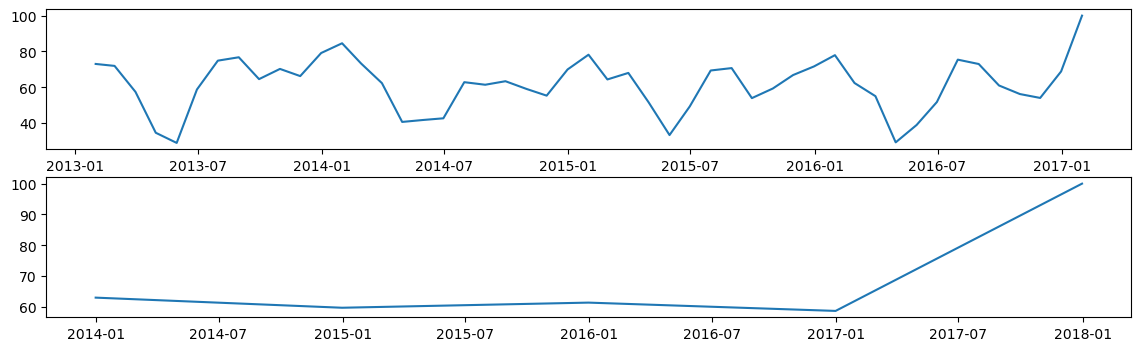

In [11]:
plt.rcParams['figure.figsize'] = [14, 4]
annual_hum = data[['humidity']].resample('A').mean()
monthly_hum =data[['humidity']].resample('M').mean()
fig, axes = plt.subplots(2,1)
axes[0].plot(monthly_hum)
axes[1].plot(annual_hum)

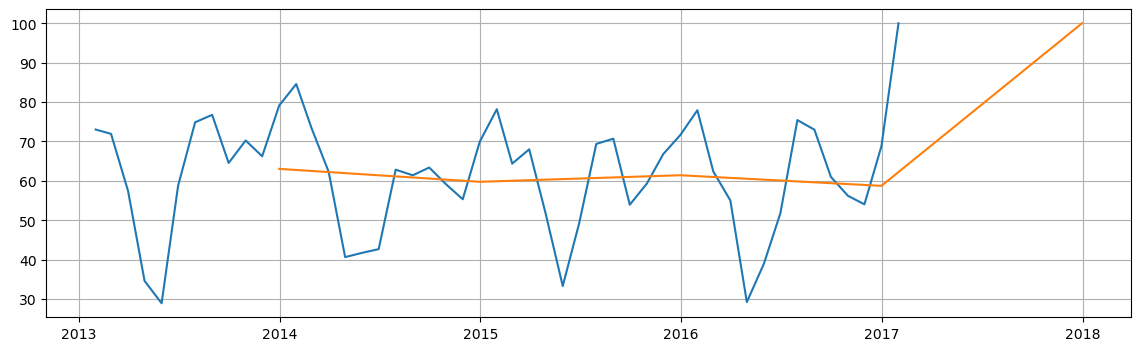

In [12]:
plt.plot(monthly_hum)
plt.plot(annual_hum)
plt.grid();

## Assessing Stationarity:
I have done the following checks to assess the stationarity of the data
* Histogram plot
* Dickey-Fuller test
* Summary statistics

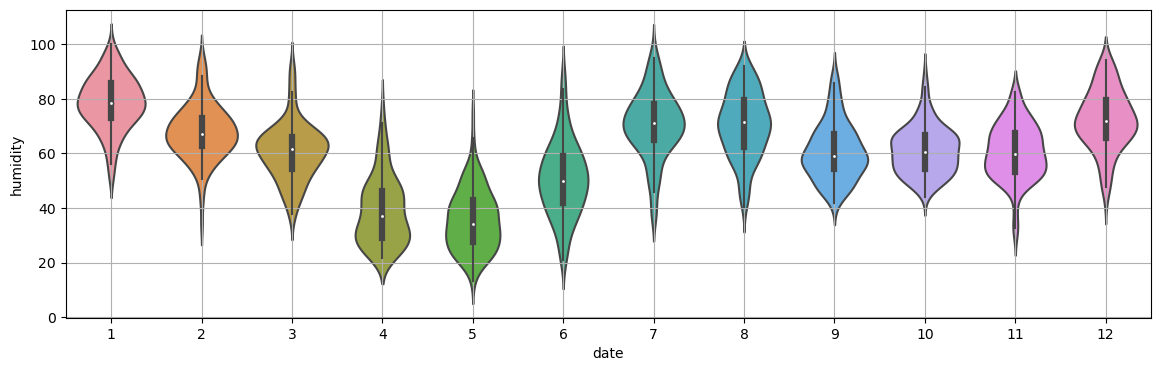

In [13]:
sns.violinplot(x=data.index.month, y=data.humidity)
plt.grid();

In [14]:
chunks = np.split(data.humidity, indices_or_sections=17)

In [15]:
mean_vals = np.mean(chunks,axis=1)
var_vals = np.var(chunks,axis=1)
vals = {'mean_vals': mean_vals , 'var_vals': var_vals}
mean_var = pd.DataFrame(vals)
mean_var

,mean_vals,var_vals
0,67.584510,155.765468
1,39.760811,254.454181
2,70.881741,145.119857
3,69.550111,71.387891
4,79.157046,108.337503
5,46.703488,151.317990
6,55.188828,233.942932
7,59.748200,99.063556
8,70.870847,131.660193
9,56.999169,269.113698


In [16]:
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

<Axes: >

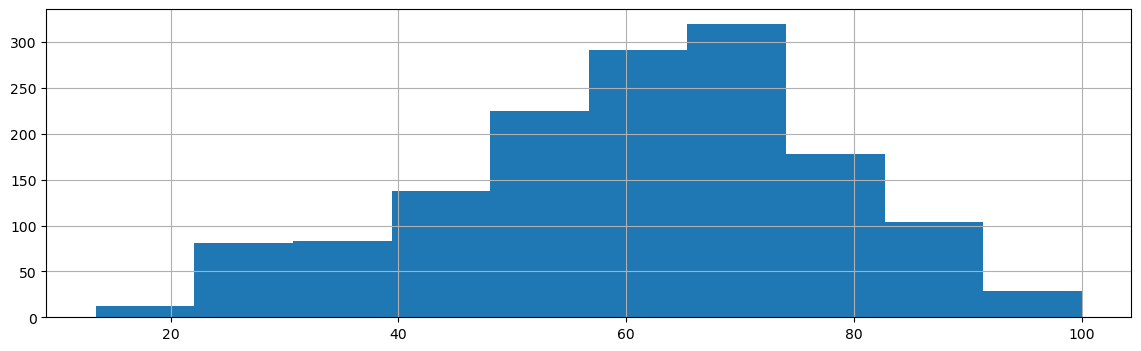

In [17]:
data.humidity.hist()

In [18]:
data['log_ss'] = np.log1p(data['humidity'])

<Axes: >

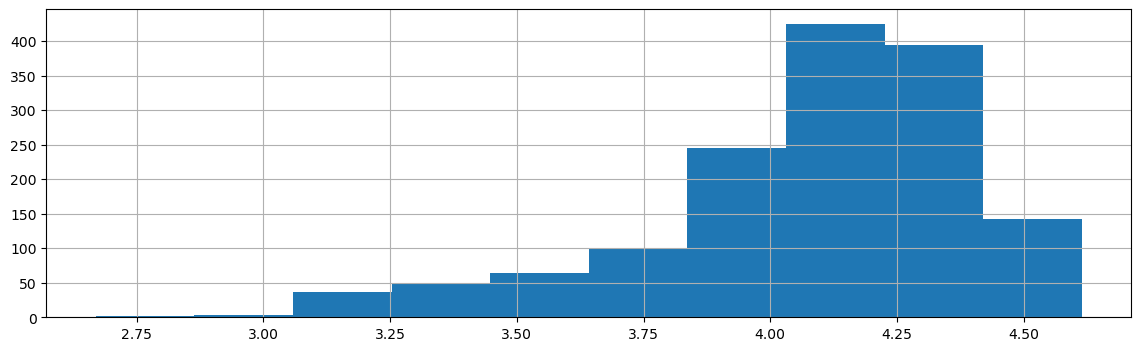

In [19]:
data['log_ss'].hist()

Test Statistic            -3.675577
p-value                    0.004470
Lags Used                 15.000000
Observations Used       1446.000000
Critical Value (1%)       -3.434880
Critical Value (5%)       -2.863541
Critical Value (10%)      -2.567835
dtype: float64


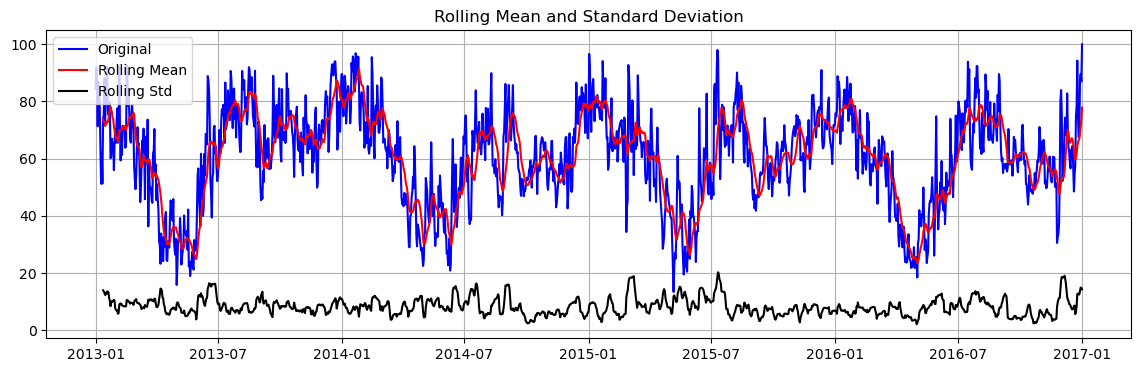

In [20]:
dftest(data['humidity'].dropna())

The p-value is less than 0.05 so that we can reject the null hypothesis, hence the data is stationary.

## Model and Parameter Selection:
I have used the Autocorrelation function and partial autocorrelation function plots to determine the parameters of the model. The plots are as shown below.


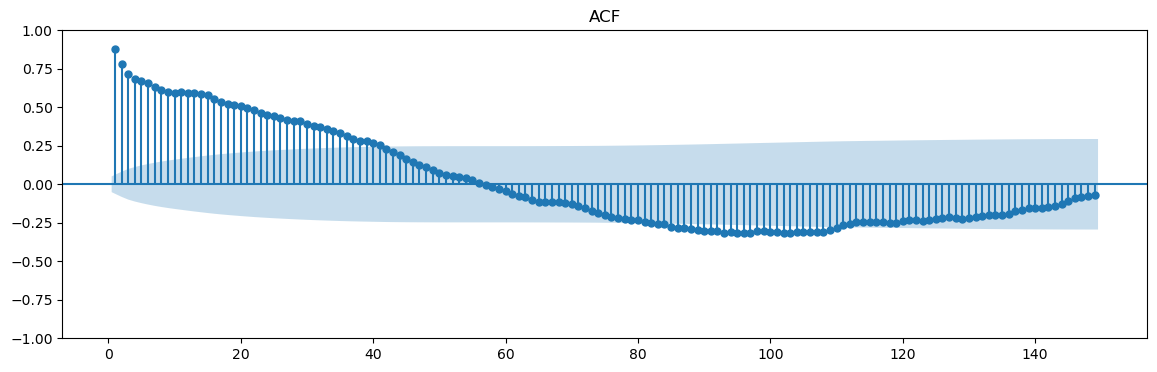

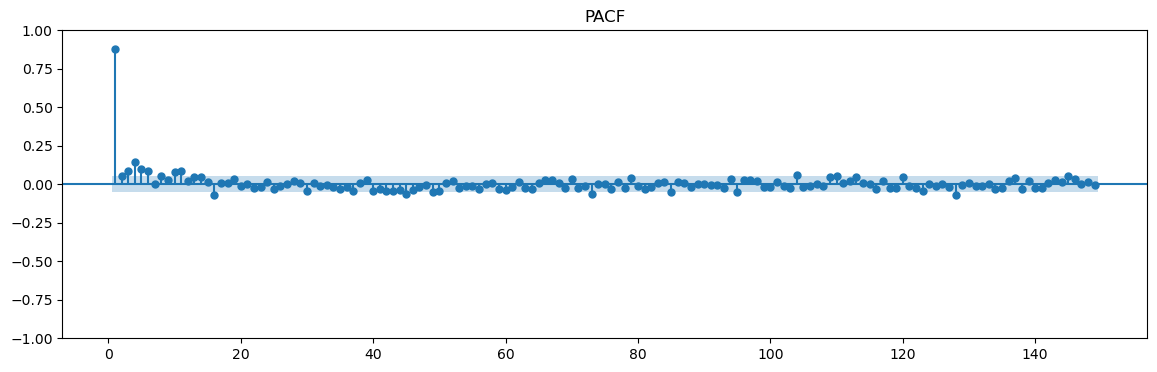

In [21]:
fig = sm.tsa.graphics.plot_acf(data.humidity, lags=range(1,150), alpha=0.05, title = 'ACF')
fig = sm.tsa.graphics.plot_pacf(data.humidity, lags=range(1,150), alpha=0.05, title = 'PACF')

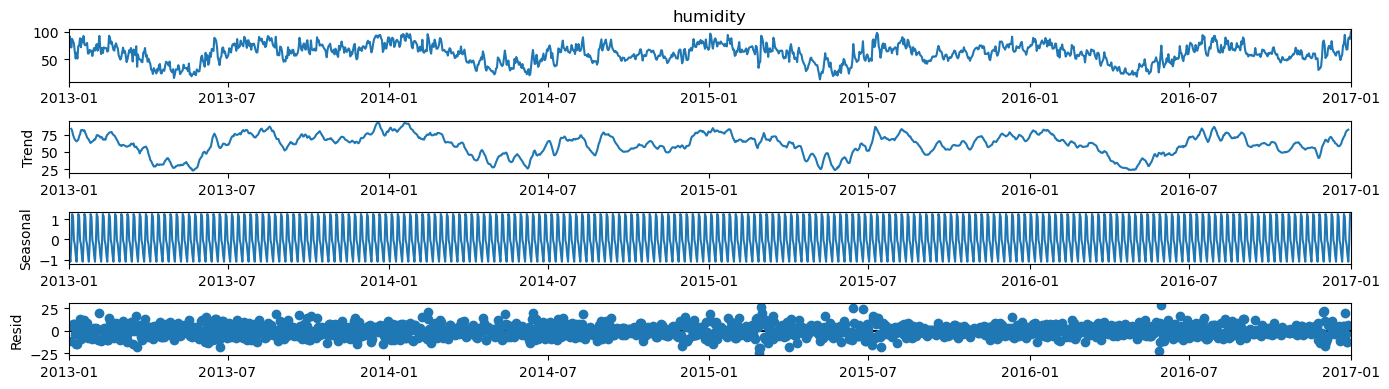

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(data.humidity,period = None).plot();

From the PACF we can say that p=2 and q=2, though there is no trend we can observe a seasonal component in the humidity. Hence, I’m choosing the SARIMA model with no d-component.

In [23]:
sar = sm.tsa.statespace.SARIMAX(data.humidity, 
                                order=(2,0,0), 
                                seasonal1_order=(0,0,2,12), 
                                trend='c').fit()
sar.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49815D+00    |proj g|=  4.60783D-03

At iterate    5    f=  3.49814D+00    |proj g|=  1.09110D-04

At iterate   10    f=  3.49814D+00    |proj g|=  4.29955D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   4.184D-05   3.498D+00
  F =   3.4981385440664625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               humidity   No. Observations:                 1462
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -5114.279
Date:                Wed, 05 Jul 2023   AIC                          10236.557
Time:                        03:33:32   BIC                          10257.707
Sample:                    01-01-2013   HQIC                         10244.446
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.9551      0.879      7.912      0.000       5.232       8.678
ar.L1          0.8331      0.025     33.359      0.000       0.784       0.882
ar.L2          0.0531      0.024      2.225      0.026       0.006       0.100
sigma2        63.9151      1.852     34.516      0.000      60.286      67.544
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               209.68
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We have to check the distribution of the residuals, and the autocorrelation plot of the residuals to check the compatibility of our model. The plots are shown below 

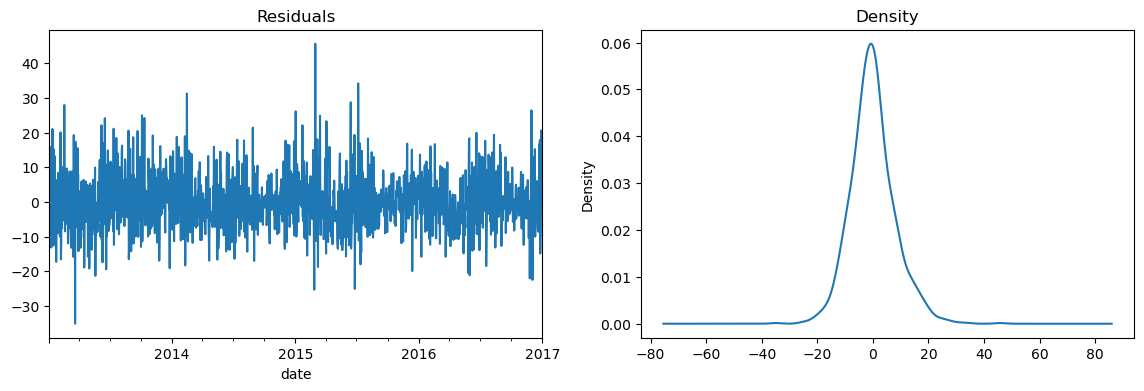

In [24]:
residuals = sar.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

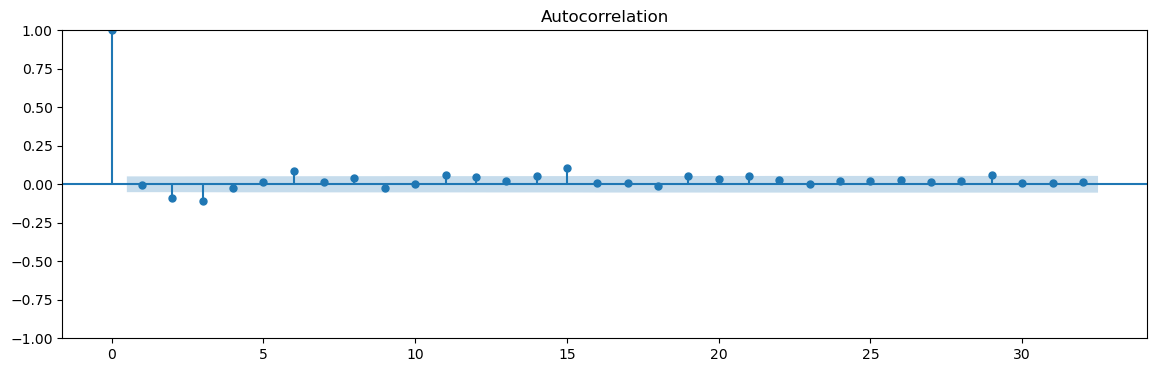

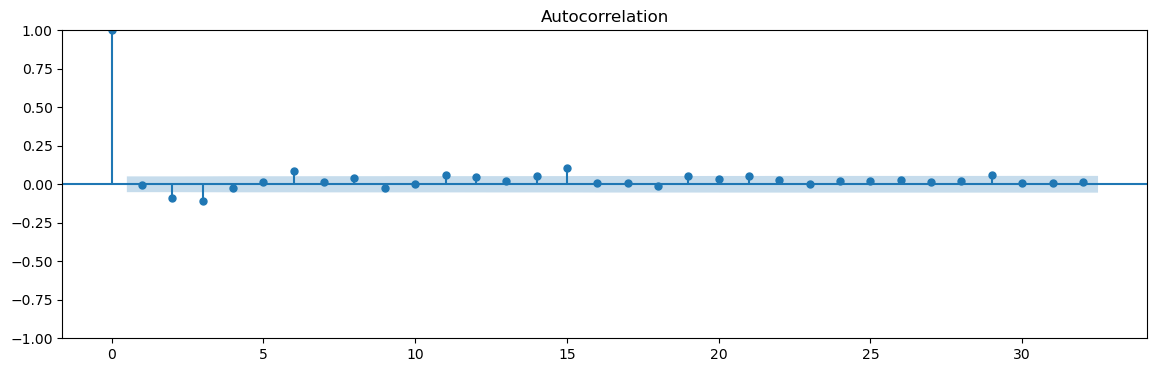

In [25]:
acf_res = sm.tsa.graphics.plot_acf(residuals)

pacf_res = sm.tsa.graphics.plot_acf(residuals)

We can see that the residuals are random and their density is exhibiting a normal distribution. On the other hand, there are no significant spikes in the lower lags of the ACF plot of the residuals, thus the residuals are close to white noise. Hence, we can proceed with the prediction and forecasting.

## Prediction and Forecasting:

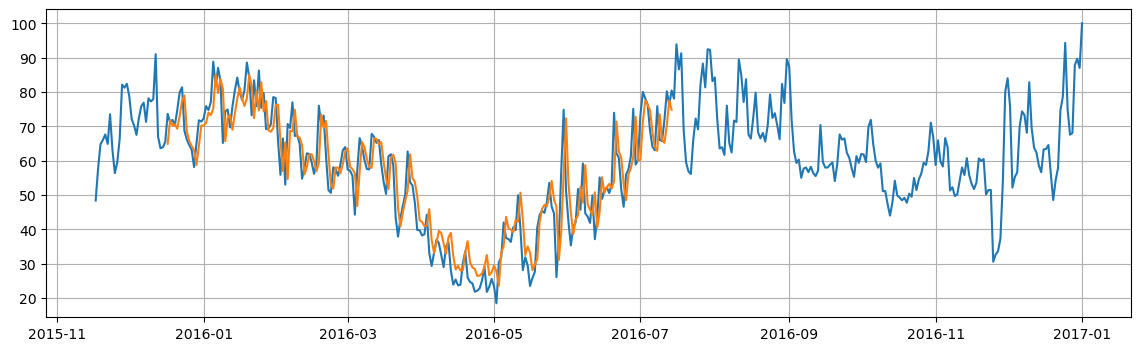

In [26]:
data['forecast'] = sar.predict(start = 1080, end= 1290, dynamic=False)  
plt.plot(data[1050:][['humidity', 'forecast']])
plt.grid();

We can see that the model is doing a good job of predicting humidity on our training data. Let’s assess the model performance on future forecasting.

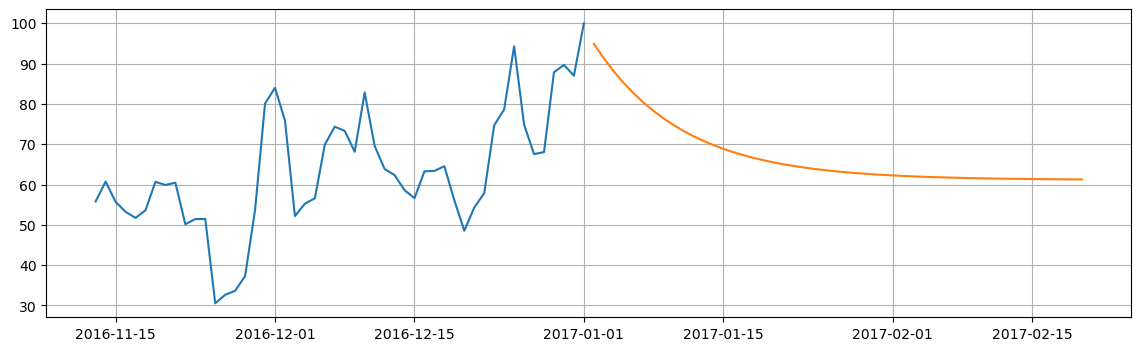

In [27]:
future_fcst = sar.get_forecast(50)
# That will have a method to pull in confidence interval 
confidence_int = future_fcst.conf_int(alpha = 0.01)
# Has an attribute to pull in predicted mean
fcst = future_fcst.predicted_mean
# Plot predictions and confidence intervals
plt.plot(data.humidity[-50:])
plt.plot(fcst)

plt.grid()

## Appendix:

In [28]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data.humidity, order = (2,0,2))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 1462
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -5077.158
Date:                Wed, 05 Jul 2023   AIC                          10166.317
Time:                        03:33:35   BIC                          10198.042
Sample:                    01-01-2013   HQIC                         10178.151
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.1833      4.028     15.436      0.000      54.288      70.079
ar.L1          1.5152      0.065     23.194      0.000       1.387       1.643
ar.L2         -0.5233      0.063     -8.273      0.0

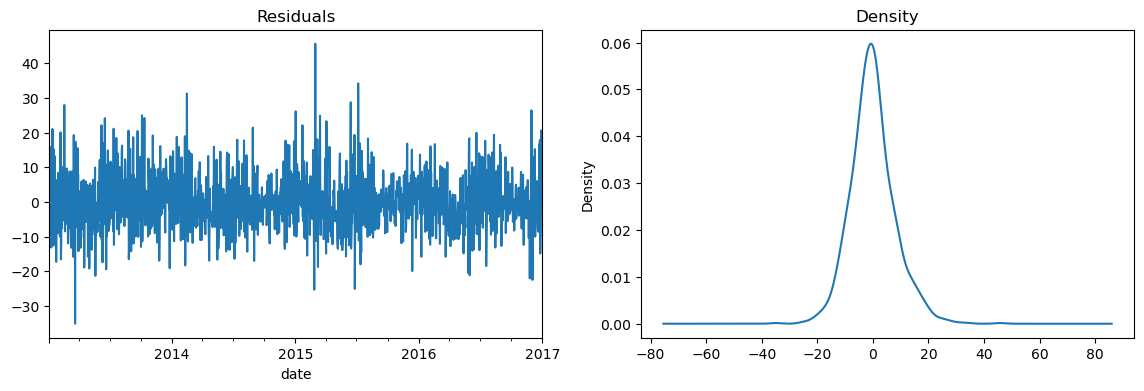

In [29]:
residuals1 = model.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

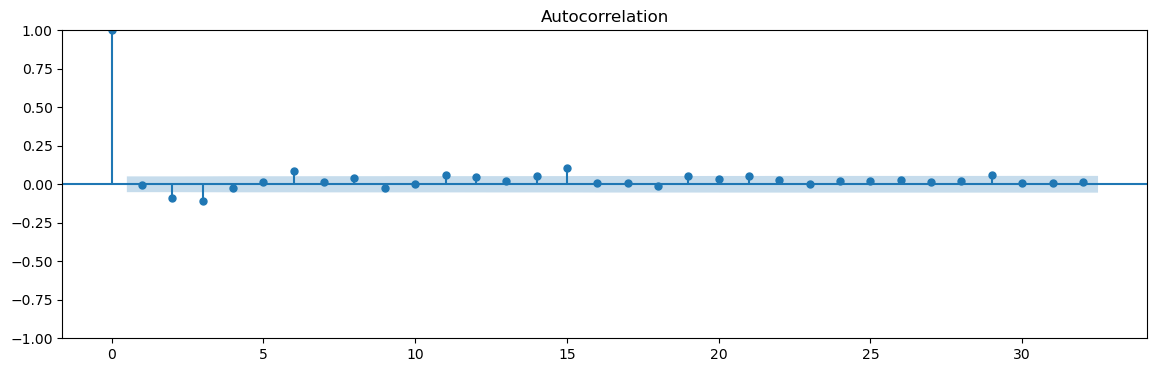

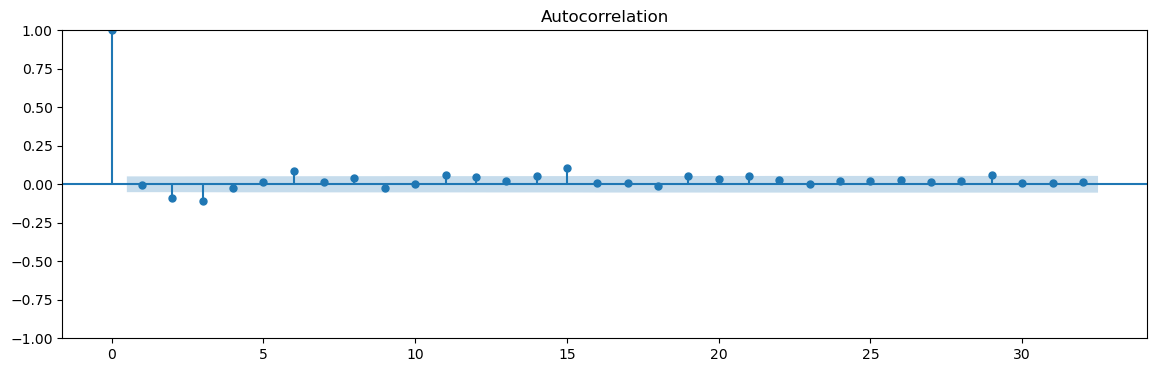

In [30]:
acf_res = sm.tsa.graphics.plot_acf(residuals)

pacf_res = sm.tsa.graphics.plot_acf(residuals)